# Implementar un sistema de inferencia difusa para controlar un péndulo invertido
---

## Análisis del modelo físico del péndulo invertido

Las constantes del modelo físico son las siguientes:

In [1]:
from math import sin, cos, pow, pi

#--------------------------------------------------
# Constantes del modelo
#--------------------------------------------------
g = 9.81    # [m/s^2]   Aceleración de la gravedad
F = 0       # [N]       Fuerza externa
m = 0.2     # [Kg]      Masa del péndulo
l = 0.5     # [m]       Longitud del péndulo
M = 2       # [Kg]      Masa del carro
#--------------------------------------------------

A continuación se calcula el modelo en el tiempo, sin aplicar ningún tipo de control:

In [2]:
def update(x, dt, F):

    x_t = x

    num = g * sin(x[0]) + cos(x[0]) * (- F - m * l * pow(x[1], 2) * sin(x[0])) / (M + m)
    den = l * (4/3 - m * pow(cos(x[0]), 2) / (M + m))

    x_t[2] = num / den

    x_t[1] = x[1] + x[2]*dt
    x_t[0] = x[0] + x[1]*dt + x[2]*pow(dt, 2)/2

    return x_t

In [3]:
MAX_ITER = 2000

dt = 0.001
t = 0

x = [-pi + 0.01, 0, 0]

pos = []
vel = []
acel = []
time = []

while(t < MAX_ITER):

    pos.append(x[0])
    vel.append(x[1])
    acel.append(x[2])

    x = update(x, dt, 0)

    time.append(t)

    t += dt

Las gráficas de ángulo $\theta$, velocidad angular y aceleración angular en el tiempo son:

In [4]:
from matplotlib import pyplot as plt

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 5))

ax0.plot(time, pos, label="theta")
ax0.grid()
ax0.legend(loc="upper right")

ax1.plot(time, vel, color='g', label="velocidad")
ax1.grid()
ax1.legend(loc="upper right")

ax2.plot(time, acel, color='r', label="aceleración")
ax2.grid()
ax2.legend(loc="upper right")

plt.show()

<Figure size 1600x500 with 3 Axes>

A pesar de que el modelo no considera ningún tipo de amortiguamiento, puede observarse cómo el sistema "pierde energía". Esto es debido a que el análisis es discreto, y a lo largo de las iteraciones se acumula un error cada vez que el péndulo llega a los extremos, produciendo un efecto similar al de un amortiguamiento.

## Definición de las variables linguísticas y los conjuntos borrosos de entrada

Se elige como variables de entrada el ángulo $\theta$ y la velocidad angular. Ambos conjuntos borrosos pueden tomar valores *MN*, muy negativo, *N*, negativo, *Z*, cero, *P*, positivo y *MP*, muy positivo.

In [5]:
from numpy import arange
from matplotlib import pyplot as plt
from math import pi
from fuzzy_logic import generate_profile

T_STEP = 0.001      # [rad]
V_STEP = 0.005      # [rad/s]
A_STEP = 0.01
F_STEP = 0.05

theta = []
v = []

ang_vel = 15
force_mag = 10

theta.append(arange(-2*pi, 2*pi+T_STEP, T_STEP))
v.append(arange(-ang_vel, ang_vel+V_STEP, V_STEP))
for i in range(0, len(v[0])):
    v[0][i] = round(v[0][i], 3)

# Generación de conjuntos borrosos de entrada

# Conjunto borroso de theta:
theta.append({})
theta[1]['MN'] = generate_profile(-pi/4, theta[0], max=-pi/6)
theta[1]['N'] = generate_profile(-pi/9, theta[0], min=-pi/3, max=0)
theta[1]['Z'] = generate_profile(0, theta[0], min=-pi/6, max=pi/6)
theta[1]['P'] = generate_profile(pi/9, theta[0], min=0, max=pi/3)
theta[1]['MP'] = generate_profile(pi/4, theta[0], min=pi/6)

# Conjunto borroso de velocidad angular:
v.append({})
v[1]['MN'] = generate_profile(-9, v[0], max=-3.75)
v[1]['N'] = generate_profile(-3.5, v[0], min=-6.5, max=-0.03*pi)
v[1]['Z'] = generate_profile(0, v[0], min=-3, max=3)
v[1]['P'] = generate_profile(3.5, v[0], min=0.03*pi, max=6.5)
v[1]['MP'] = generate_profile(9, v[0], min=3.75)


Obteniendose los siguientes conjuntos borrosos para cada variable:

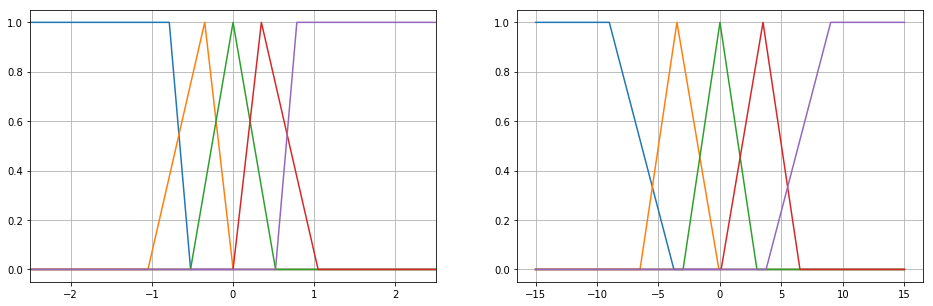

In [6]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
for i in theta[1].values():
    ax0.plot(theta[0], i, label=i)
ax0.grid()
ax0.set_xlim(-2.5, 2.5)

for i in v[1].values():
    ax1.plot(v[0], i, label=i)
ax1.grid()

plt.show()


## Definición de las variable linguísticas y los conjuntos borrosos de salida

Se elige como variable de salida del sistema la fuerza de acción *F* sobre el carro (base del péndulo invertido). Los diferentes conjuntos se denominan igual, solo cambia el rango de valores reales que puede tomar:

In [7]:
F = []
F.append(arange(-7*force_mag, 7*force_mag+F_STEP, F_STEP))

# Generación de conjuntos borrosos de salida
F.append({})
F[1]['MN'] = generate_profile(-5*force_mag, F[0], max=-3.5*force_mag)
F[1]['N'] = generate_profile(-1.25*force_mag, F[0], min=-3.75*force_mag, max=0)
F[1]['Z'] = generate_profile(0, F[0], min=-1.5*force_mag, max=1.5*force_mag)
F[1]['P'] = generate_profile(1.25*force_mag, F[0], min=0, max=3.75*force_mag)
F[1]['MP'] = generate_profile(5*force_mag, F[0], min=3.5*force_mag)


Obteniendose los siguientes conjuntos borrosos para la variable F:

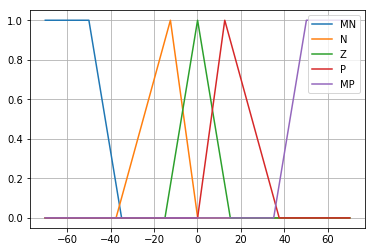

In [8]:
for i in theta[1]:
    plt.plot(F[0], F[1][i], label=i)
plt.grid()
plt.legend(loc="upper right")

## Implementación de la inferencia borrosa mediante base de reglas tipo if-then

Las base de reglas que se estableció para la inferencia borrosa se expone en la siguiente tabla:

    |    | MN | N  | Z  | P  | MP |
    | -- | -- | -- | -- | -- | -- |
    | MN | MN | MN | MN | N  | Z  |
    | N  | MN | MN | N  | Z  | P  |
    | Z  | MN | N  | Z  | P  | MP |
    | P  | N  | Z  | P  | MP | MP |
    | MP | Z  | P  | MP | MP | MP |

la cual está implementada en python como un diccionario de diccionarios. Esto debe leerse con la primera key del diccionario como el conjunto de theta y cada key dentro de el diccionario de theta como los conjuntos de theta punto. El valor resultante es un string que caracteriza el conjunto borroso de F. Por ejemplo, R['Z']['MP'] == 'MP' lo que significa que si theta es cero y theta punto es muy positiva entonces la fuerza debe ser muy positiva

In [9]:
R = {
    'MN': {'MN': 'MN', 'N': 'MN', 'Z': 'MN', 'P': 'N', 'MP': 'Z'},
    'N': {'MN': 'MN', 'N': 'MN', 'Z': 'N', 'P': 'Z', 'MP': 'P'},
    'Z': {'MN': 'MN', 'N': 'N', 'Z': 'Z', 'P': 'P', 'MP': 'MP'},
    'P': {'MN': 'N', 'N': 'Z', 'Z': 'P', 'P': 'MP', 'MP': 'MP'},
    'MP': {'MN': 'Z', 'N': 'P', 'Z': 'MP', 'P': 'MP', 'MP': 'MP'}
    }

## Obtención de la fuerza dadas las condiciones iniciales

Dadas ciertas condiciones iniciales probamos lo que hace el controlador difuso para un delta_t. Primero obtenemos los valores de pertenencia de las condiciones iniciales a cada conjunto borroso de su variable lingüística.

In [10]:
from fuzzy_logic import fuzzifier, defuzzifier
from numpy import zeros

cond_inic = [pi/6, pi/4]

value = zeros(3)
value[0] = cond_inic[0]
value[1] = cond_inic[1]
value[2] = 0

Force = 0

mu_theta = fuzzifier(value[0], theta)
mu_thetadot = fuzzifier(value[1], v)

print(mu_theta)
print(mu_thetadot)


{'MN': 0, 'N': 0, 'Z': 0.0, 'P': 0.7507163323782235, 'MP': 0.0}
{'MN': 0, 'N': 0, 'Z': 0.7366666666666667, 'P': 0.20411160058737152, 'MP': 0}


Luego se realiza el cálculo de los antecedentes de cada regla en las que intervienen los valores no nulos de pertenencia que acabamos de calcular. 

In [11]:
v_antec = {'MN': 0, 'N': 0, 'Z':0, 'P': 0, 'MP': 0}

for theta_r in R.keys():
    for thetadot_r in R[theta_r].keys():
        if (mu_thetadot[thetadot_r] == 0) or (mu_theta[theta_r] == 0): 
            continue

        antec = min(mu_theta[theta_r], mu_thetadot[thetadot_r])

        if (antec > v_antec[R[theta_r][thetadot_r]]):
            v_antec[R[theta_r][thetadot_r]] = antec


Posteriormente ealizamos la implicación de cada regla. Esto genera el truncamiento de los conjuntos borrosos de salida de la variable fuerza. Finalmente encontramos el valor nítido de fuerza usando el desborrosificador de centro de gravedad conjunto truncado.  

fuerza= 27.149999999994478


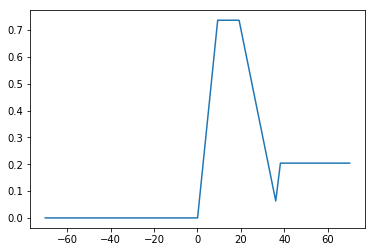

In [12]:
# Implicación/truncado de conjuntos de salida:    
F_out = zeros(len(F[0]))

for i in F[1].keys():
    for j in range(0, len(F[0])):

        min_temp = min(F[1][i][j], v_antec[i])

        if (min_temp > F_out[j]):
            F_out[j] = min_temp            

plt.plot(F[0], F_out)
force = defuzzifier(F_out, F[0])

print("fuerza=",force)


## Controlador difuso

Luego de verificar el funcionamiento del algoritmo difuso pasamos a realizar un control de posición el cual se basa en ejecutar lo antes explicado iterativamente y calculando las nuevas posiciones y velocidades angulares con el modelo del péndulo invertido también ya descripto.

In [13]:
from fuzzy_logic import fuzzy_control
from math import pi
from numpy import zeros

cond_inic = [pi/4, pi/8]

x = zeros(3)
x[0] = cond_inic[0]
x[1] = cond_inic[1]
x[2] = 0

pos = []
vel = []
acel = []
time = []

Force = 0
force_hist = []
t = 0
dt = 0.05


while(t < 8):

    x = update(x, dt, Force)

    pos.append(x[0])
    vel.append(x[1])
    acel.append(x[2])

    Force = fuzzy_control([x[0], x[1]], theta, v, R, F)
    force_hist.append(Force)
    time.append(t)

    t += dt


Para un ángulo inicial de pi/4 rad y una velocidad angular inicial de pi/8 rad/s obtenemos estas respuestas de posición, velocidad y aceleración angulares. 

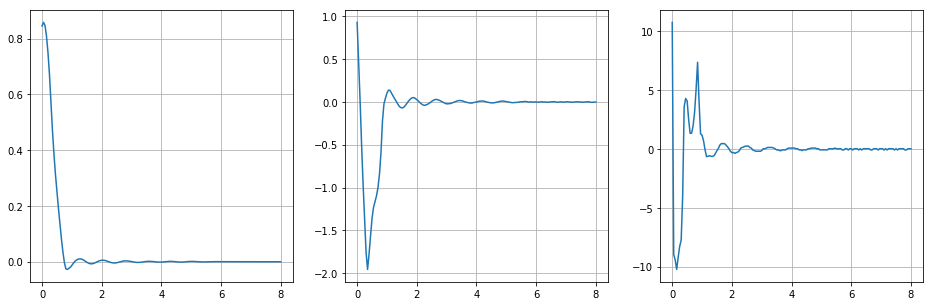

In [14]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 5))
ax0.plot(time, pos)
ax0.grid()
ax1.plot(time, vel)
ax1.grid()
ax2.plot(time, acel)
ax2.grid()


Además el perfil de fuerzas es el siguiente

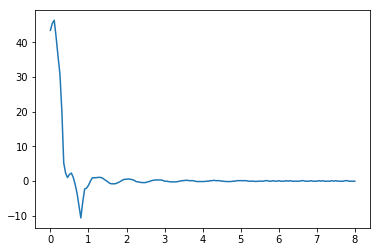

In [15]:
plt.plot(time, force_hist)
plt.show()

## Levantar el péndulo

También existe la posibilidad de levantar el péndulo desde una posición inicial vertical, hacia abajo (pi radianes). 

In [18]:
from fuzzy_logic import fuzzy_control
from math import pi
from numpy import zeros

cond_inic = [pi, 0]

x = zeros(3)
x[0] = cond_inic[0]
x[1] = cond_inic[1]
x[2] = 0

pos = []
vel = []
acel = []
time = []

Force = 0
force_hist = []
t = 0
dt = 0.05


while(t < 8):

    x = update(x, dt, Force)

    pos.append(x[0])
    vel.append(x[1])
    acel.append(x[2])

    Force = fuzzy_control([x[0], x[1]], theta, v, R, F)
    force_hist.append(Force)
    time.append(t)

    t += dt


Y las curvas obtenidas de ángulo, velocidad, aceleración y fuerza son las siguientes

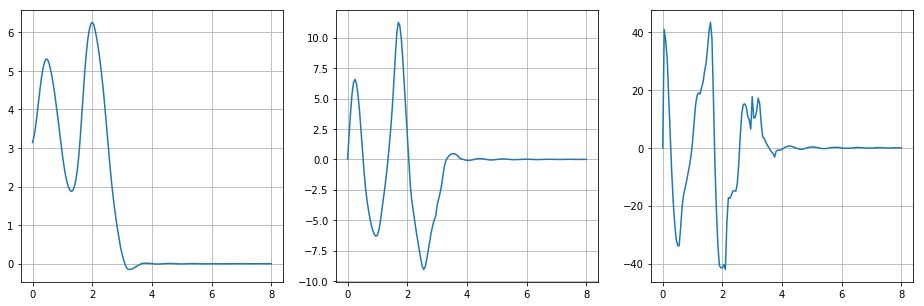

In [19]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 5))
ax0.plot(time, pos)
ax0.grid()
ax1.plot(time, vel)
ax1.grid()
ax2.plot(time, acel)
ax2.grid()

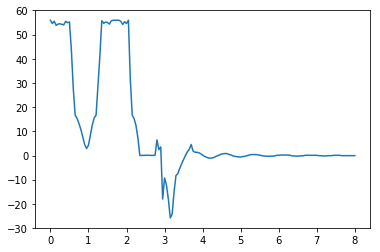

In [20]:
plt.plot(time, force_hist)
plt.show()